# Analysis of Compressor Booster Stations using Symmetry's JSON API

Within the natural gas pipeline network, compressor booster stations hold a crucial role in orchestrating gas transportation from individual well sites to end users. They are strategically situated along the gathering and transportation network to effectively maintain pressure and flow of gas to market.

The formation of hydrates in natural gas systems has been a widely common problem to the gas processing industry. Methanol has been used as a hydrate inhibitor for nearly as long as the hydrate problem has existed.

In this study, we use Symmetry to build a proxy booster station model to evaluate methanol consumption in a gathering system containing 18 compressor booster stations.

This analysis is based on the data in the following reference:<br>
*Bullin, K.; Bulling, J. Optimizing Methanol Usage for Hydrate Inhibition in a Gas Gathering System. Presented at the 83<sup>rd</sup> Annual GPA Convention, 2004.*

## 1. Imports

In [1]:
import os, sys
import pandas as pd, numpy as np
from IPython.display import Image

from utils.sym_client import SymClient
from utils.plots import (PlotHydrateTemperature,
                        PlotMethanolRates,
                        PlotCoolerSensitivity)

IMG_PATH = os.path.join(os.path.abspath(""), "images")
DATA_PATH = os.path.join(os.path.abspath(""), "data")
FLOW_HEADER = "Flow (MMSCFD)"
T_HEADER = "T (degF)"
P_HEADER = "P (psig)"
PORT = 80

%load_ext autoreload
%autoreload 2

## 2. Field Data

The gathering system spans 125 miles and collects gas from wells using a low pressure system. The gathering system is a wet gas system designed for hydrate inhibition with methanol.

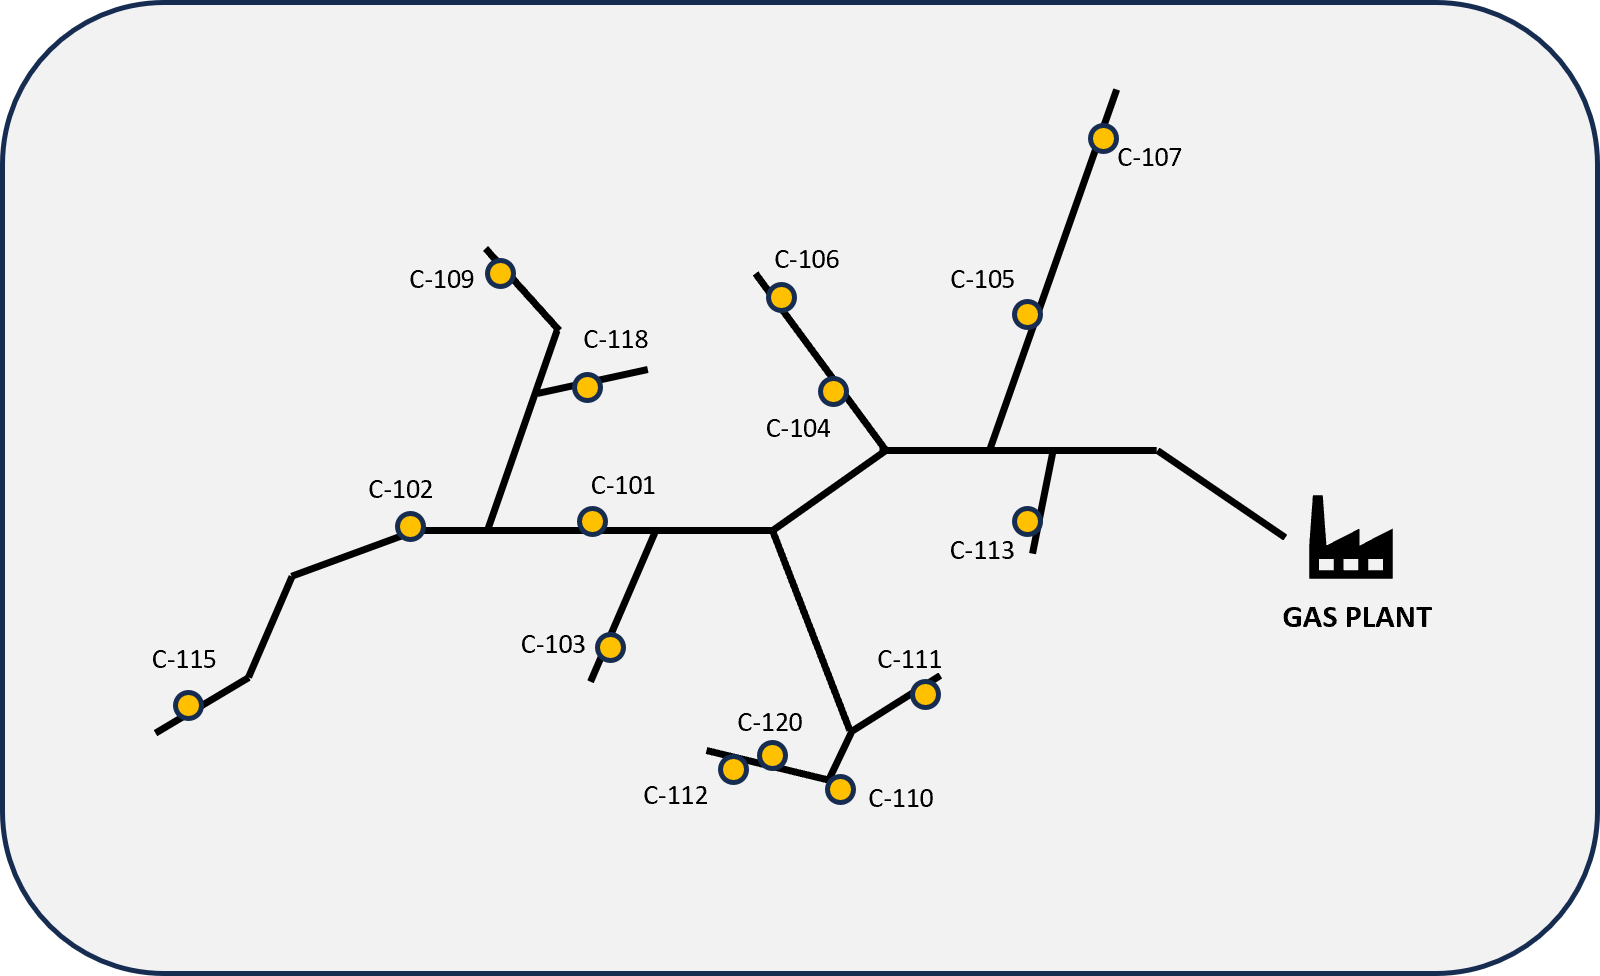

In [2]:
Image(filename=os.path.join(IMG_PATH, "Gathering_System_v0.PNG"))

Field data for pressure, temperature and gas flow is provided for summer and winter scenarios.

### 2.1. Gathering Information for Summer Scenario

In [3]:
summer_data = pd.read_csv(os.path.join(DATA_PATH, "summer.csv"))
summer_data.head(2)

,Station,Flow (MMSCFD),T (degF),P (psig)
0,C-101,0.987,123,639
1,C-102,2.462,137,663


### 2.2. Gathering Information for Winter Scenario

In [4]:
winter_data = pd.read_csv(os.path.join(DATA_PATH, "winter.csv"))
winter_data.head(2)

,Station,Flow (MMSCFD),T (degF),P (psig)
0,C-101,0.930,77,640
1,C-102,3.045,145,678


## 3. Symmetry Model

At each booster station, the gas is compressed using three stages with interstage and final stage cooling. The Symmetry model created for the booster station contains a compressor, a cooler and a scrubber for each stage.

Based on the typical composition range provided in the paper, a reference composition was selected to perform the analysis. Water content in the feed gas is adjusted as per saturation conditions using a Saturation unit op.

The first two stages are set with a compression ratio between 2 and 2.5, whereas the last stage is set with an outlet pressure according to the field data provided, resulting in a compression ratio in similar range.<br>
The intercoolers are set to an outlet temperature of 150&deg;F, whereas the final cooler is set to 160&deg;F.

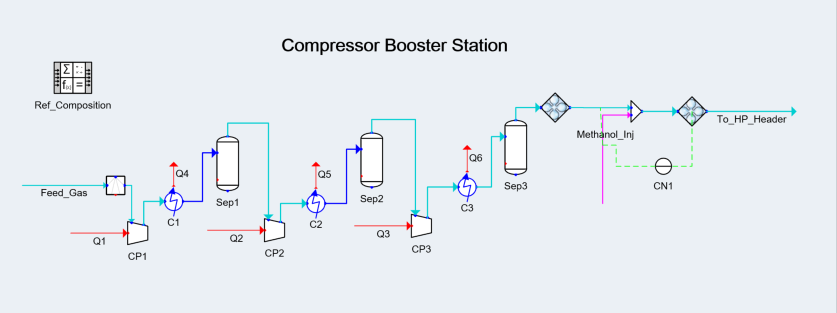

In [5]:
Image(filename=os.path.join(IMG_PATH, "Gathering_System_Symmetry.PNG"))

We implement a Symmetry client to run case studies in the backend, leveraging Symmetry's JSON API to generate insights on methanol consumption in the distribution network.

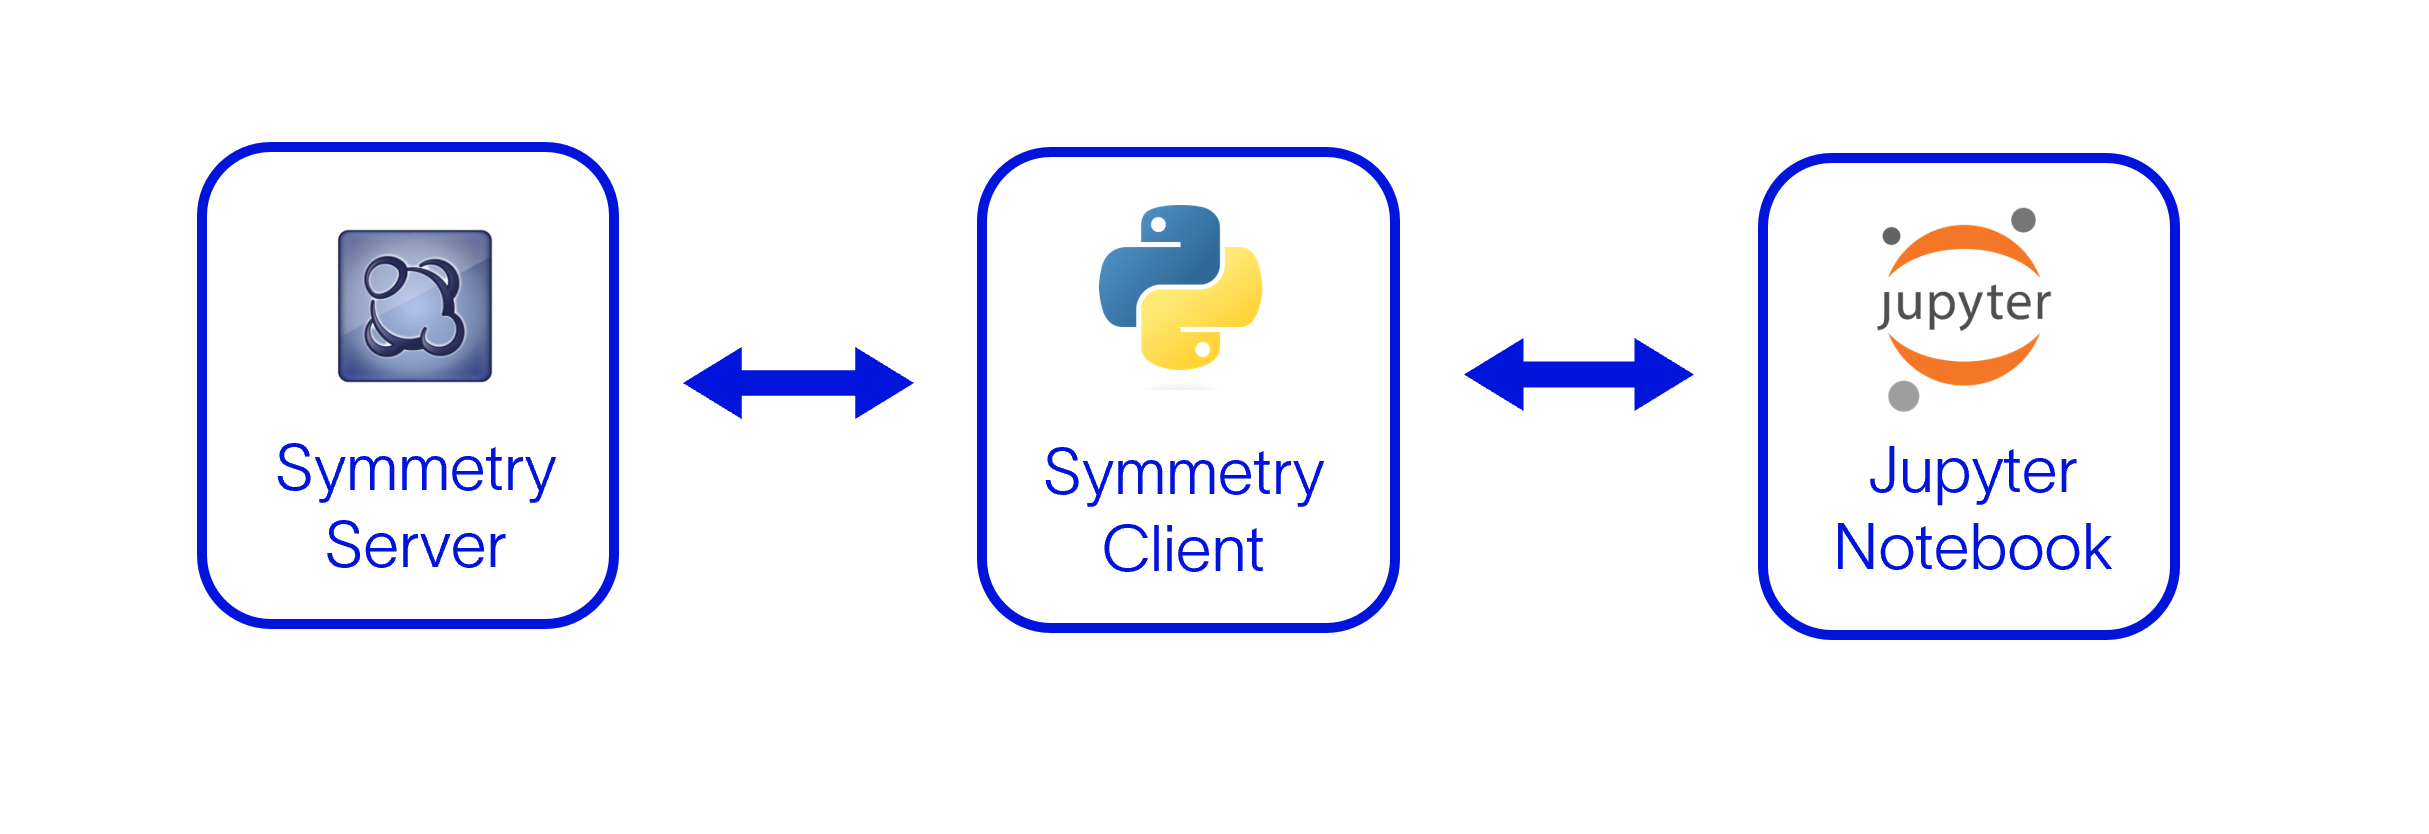

In [6]:
Image(filename=os.path.join(IMG_PATH, "SymClient.PNG"))

To use the this structure, we instantiate a client and use it to send simulation requests and receive results.

In [7]:
case_path = os.path.join(DATA_PATH, "BoosterStation.vsym")
sym = SymClient(case_path, port=PORT)

Furthermore, we need to enable the server in the Symmetry case.<br>
In the Symmetry installation folder, navigate to the UI folder and find the VMGStandaloneServer.exe file.

```Symmetry > UI > VMGStandaloneServer.exe```

After running the executable, the following prompt will show:

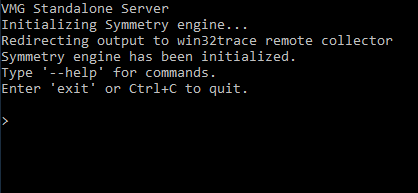

In [8]:
Image(filename=os.path.join(IMG_PATH, "Symmetry_Server_1.PNG"))

To start the Symmetry server, run the following command in the prompt:

```starthttp -h localhost -p <port> -w 1```

Note: In the command above, replace ```<port>``` with the required port number.<br>
Once the server is started, the prompt window will look as follows:


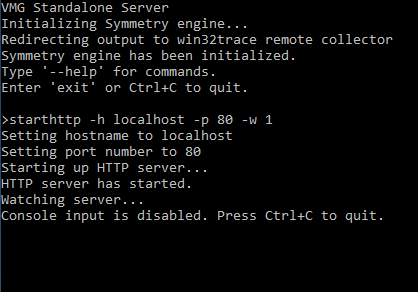

In [9]:
Image(filename=os.path.join(IMG_PATH, "Symmetry_Server_2.PNG"))

As API calls are made to the server, you will be able to visualize the response status in the command prompt window.

## 4. Data Analysis

### 4.1. Hydrate Formation Temperature

Hydrate formation temperature is calculated for each booster station.<br>
First, we set up the dependent and independent variables. Then, we run the case study and plot results.

In [10]:
def SetUpVariables(data):

    '''
    Independent variables:
        - Gas Distribution Temperature
        - Gas Distribution Pressure
        
    Dependent variables:
        - Hydrate Formation Temperature
    '''

    ind = [
        {
            'label': 'Gas Distribution Temperature',
            'path': '/C3.OutT',
            'unit': 'F',
            'vals': data[T_HEADER].values.tolist()
        },
        {
            'label': 'Gas Distribution Pressure',
            'path': '/CP3.Out.P',
            'unit': 'psia',
            'vals': data[P_HEADER].values.tolist()
        }
    ]
    dep = [
        {
            'label': 'Hydrate Formation T',
            'path': '/HY1.HydrateTemp',
            'unit': 'F'
        }
    ]
    
    idx = summer_data['Station'].values.tolist()

    return ind, dep, idx

In [11]:
# Get dependent and independent variables
ind, dep, idx = SetUpVariables(summer_data)
# Run case study
results = sym.SolveCaseStudy(ind, dep, idx)
# Check results
results.head(2)

,Gas Distribution Temperature (F),Gas Distribution Pressure (psia),Hydrate Formation T (F)
C-101,123,639,61.232778
C-102,137,663,61.661261


In [12]:
PlotHydrateTemperature(results, 'Hydrate Formation T (F)')

Based on operating conditions, hydrate formation temperature is between 60&deg;F and 65&deg;F for almost every station. <br>
Experience has shown that the system must be inhibited down to a temperature of about 20&deg;F in winter and 40&deg;F in summer.

Now, let's evaluate the required methanol injection rates to achieve this goal.

### 4.2. Summer and Winter Methanol Consumption

Here we use the Symmetry client to obtain the required methanol injection.

In [13]:
SUMMER_INHIB_TEMP = 40.0
WINTER_INHIB_TEMP = 20.0

def SetUpVariables(data):

    '''
    Independent variables:
        - Gas Distribution Temperature
        - Gas Distribution Pressure
        - Gas volume
        
    Dependent variables:
        - Methanol Injection Rate
    '''

    ind = [
        {
            'label': 'Gas Distribution Temperature',
            'path': '/C3.OutT',
            'unit': 'F',
            'vals': data[T_HEADER].values.tolist()
        },
        {
            'label': 'Gas Distribution Pressure',
            'path': '/CP3.Out.P',
            'unit': 'psia',
            'vals': data[P_HEADER].values.tolist()
        },
        {
            'label': 'Gas Volume',
            'path': '/Feed_Gas.In.StdGasVolumeFlow',
            'unit': 'MMSCFD',
            'vals': data[FLOW_HEADER].values.tolist()
        }
    ]
    dep = [
        {
            'label': 'Methanol Injection',
            'path': '/CN1.Out',
            'unit': 'gal(US)/d'
        }
    ]
    
    idx = summer_data['Station'].values.tolist()

    return ind, dep, idx

Since the inhibition temperature is different during summer and winter, we use the "Pre-solve Commands" option to set the inhibition temperature in the controller that adjusts the injection rate.

#### 4.2.1. Summer Analysis

In [14]:
# Set up a pre-solve command
cmd = f'/CN1.Target = {SUMMER_INHIB_TEMP} F'
presolve_cmd = [cmd, { "call": "SetValues", "args": { } }]

In [15]:
# Get dependent and independent variables
ind, dep, idx = SetUpVariables(summer_data)
# Run case study
results_summer = sym.SolveCaseStudy(ind, dep, idx=idx, preSolveCmds=presolve_cmd)
results_summer["Normalized Methanol Rate (gal(US)/MMSCF)"] = results_summer['Methanol Injection (gal(US)/d)'] / results_summer['Gas Volume (MMSCFD)']
# Check results
results_summer.head(2)

,Gas Distribution Temperature (F),Gas Distribution Pressure (psia),Gas Volume (MMSCFD),Methanol Injection (gal(US)/d),Normalized Methanol Rate (gal(US)/MMSCF)
C-101,123,639,0.987,17.572816,17.804272
C-102,137,663,2.462,47.572816,19.322834


#### 4.2.2. Winter Analysis

In [16]:
# Set up a pre-solve command
cmd = f'/CN1.Target = {WINTER_INHIB_TEMP} F'
presolve_cmd = [cmd, { "call": "SetValues", "args": { } }]

In [17]:
# Get dependent and independent variables
ind, dep, idx = SetUpVariables(winter_data)
# Ran case study
results_winter = sym.SolveCaseStudy(ind, dep, idx=idx, preSolveCmds=presolve_cmd)
results_winter["Normalized Methanol Rate (gal(US)/MMSCF)"] = results_winter['Methanol Injection (gal(US)/d)'] / results_winter['Gas Volume (MMSCFD)']
# Check results
results_winter.head(2)

,Gas Distribution Temperature (F),Gas Distribution Pressure (psia),Gas Volume (MMSCFD),Methanol Injection (gal(US)/d),Normalized Methanol Rate (gal(US)/MMSCF)
C-101,77,640,0.930,12.201792,13.120207
C-102,145,678,3.045,42.201792,13.859373


#### 4.2.3. Results

In [18]:
PlotMethanolRates(results_summer, results_winter, "Normalized Methanol Rate (gal(US)/MMSCF)")

The normalized methanol requirements indicate that methanol consumption vary from 7 to 46 gal/MMSCF, depending on the booster station and the summer / winter scenario.

The amount of methanol required is highly influenced by the water content and the temperature. The operator cannot control water content at this point in the process, however, the gas distribution temperature can be manipulated by improving performance of the final cooling stage.

Let's investigate how this parameter influences methanol consumption.

### 4.3. Sensitivity on Cooler Temperature

To investigate the effect of cooler temperature on the methanol consumption, we select the booster station C-106.
This station has the highest gas distribution temperature, between 161&deg;F and 166&deg;F over the summer and winter seasons.

To perform this analysis, we vary the cooler temperature from 80&deg;F and 145&deg;F, and observe results for water content and methanol injection rates over summer and winter months.

In [19]:
# Select an average pressure as reference
P_summer = summer_data[summer_data["Station"] == "C-106"][P_HEADER].values[0]
P_winter = winter_data[winter_data["Station"] == "C-106"][P_HEADER].values[0]
pressure = 0.5*(P_summer+P_winter)

In [20]:
# Variable names
x_name = 'Gas Distribution Temperature (F)'
y_methanol_name = "Methanol Rate (gal(US)/MMSCF)"
y_water_name = "Water Content (gal(US)/MMSCF)"

In [21]:
def SetUpVariables():

    '''
    Independent variables:
        - Gas Distribution Temperature
        
    Dependent variables:
        - Methanol Injection Rate
        - Water Content
    '''

    ind = [
        {
            'label': 'Gas Distribution Temperature',
            'path': '/C3.OutT',
            'unit': 'F',
            'vals': list(range(80, 145, 5))
        }
    ]
    dep = [
        {
            'label': 'Methanol Injection',
            'path': '/CN1.Out',
            'unit': 'gal(US)/d'
        },
        {
            'label': 'Water Content',
            'path': '/S13.In.StdLiqVolumeFlows.WATER',
            'unit': 'gal(US)/d'
        }
    ]
    
    return ind, dep

def SolveSeason(inhib_T):

    """ Sensitizes on cooler temperature for each season """

    gas_flow = 1.0 # MMSCFD

    # Set up a pre-solve command
    cmd1 = f'/CP3.Out.P = {pressure} psig'
    cmd2 = f'/Feed_Gas.In.StdGasVolumeFlow = {gas_flow} MMSCFD'
    cmd3 = f'/CN1.Target = {inhib_T} F'

    presolve_cmd = [cmd1, cmd2, cmd3, { "call": "SetValues", "args": { } }]

    # Get dependent and independent variables
    ind, dep = SetUpVariables()
    # Run case study
    results = sym.SolveCaseStudy(ind, dep, preSolveCmds=presolve_cmd)

    # Since we have 1.0 MMSCFD, we can consider the rates normalized
    results.rename(columns= {
        "Methanol Injection (gal(US)/d)": y_methanol_name,
        "Water Content (gal(US)/d)": y_water_name
    }, inplace=True)

    return results

The case study involves setting up inhibition temperature and average gas distribution pressure, and sensitizing on gas distribution temperature.

In [22]:
results_summer = SolveSeason(SUMMER_INHIB_TEMP)
results_winter = SolveSeason(WINTER_INHIB_TEMP)

Analysis of results:

In [23]:
PlotCoolerSensitivity(results_summer, results_winter, x_name, y_methanol_name, y_water_name)

As indicated in the figure above, the final cooler temperature greatly influences the amount of methanol required for hydrate suppression.<br>
Higher temperatures result in greater methanol vaporization into the gas, as well as increased water content.<br>
The methanol requirement for each booster station can be reduced by lowering the final cooler temperature. Keeping a safety factor from the range of hydrate formation evaluated in section 4.1 (60&deg;F to 65&deg;F), the lower limit on the final cooler can be reduced to about 75&deg;F to 85&deg;F, which greatly reduce methanol requirement.